In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [16]:
d21 = pd.read_csv('./fully_correlated_data/data_21.csv')
d22 = pd.read_csv('./fully_correlated_data/data_22.csv')
d10 = pd.read_csv('./fully_correlated_data/data_10.csv')
d11 = pd.read_csv('./fully_correlated_data/data_11.csv')
d12 = pd.read_csv('./fully_correlated_data/data_12.csv')
d13 = pd.read_csv('./fully_correlated_data/data_13.csv')
d14 = pd.read_csv('./fully_correlated_data/data_14.csv')
d15 = pd.read_csv('./fully_correlated_data/data_15.csv')
d16 = pd.read_csv('./fully_correlated_data/data_16.csv')
d17 = pd.read_csv('./fully_correlated_data/data_17.csv')

In [21]:
comb_data = pd.concat([d10,d11,d12,d13,d14,d15,d16,d17,d21,d22], ignore_index = True)

In [24]:
comb_filt = comb_data.dropna()

#### Plot all selected boat paths

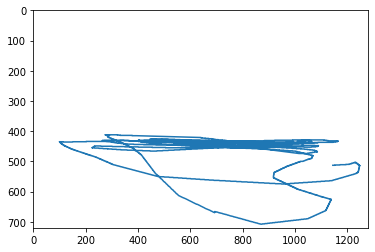

In [26]:
plt.xlim(left=0,right=1280)
plt.ylim(top=0,bottom=720)
plt.plot(comb_data.x_cent,comb_data.y_cent)

#### Define Google Earth Constants

In [27]:
RH_Point = np.array([-117.2244901, 32.6990683])
CAM = np.array([-117.2344652, 32.7029769])
RHS = (RH_Point-CAM)/np.linalg.norm(RH_Point-CAM)
RHS_Ang = np.arctan2(RHS[1],RHS[0])

### Extremely Simple Estimates
#### Find Optimal FOV Approximate

In [31]:
angles = np.arctan2(comb_data.lat_int.values,comb_data.lon_int.values)

In [32]:
comb_data['angles'] = angles

In [44]:
comb_data['angle_offset'] = angles - RHS_Ang

In [67]:
min_err = 1e10
best = None
error = []
iis = []
for i in np.arange(1,1.5,.0001):
    agr = (comb_data.angle_offset/i).values
    x_prop = (1-comb_data.x_cent/1280).values
    err = ((x_prop-agr)**2).mean()
    error.append(err)
    iis.append(i)
    if err < min_err:
        min_err = err
        best = i
        
FOV = best

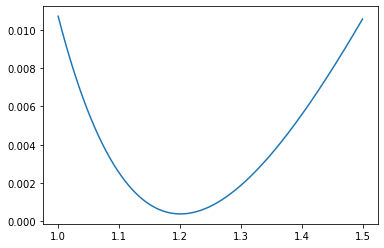

In [68]:
plt.plot(iis,error) #just look at that pretty convex loss profile *chef's kiss*

In [70]:
comb_data['angle_rel'] = comb_data.angle_offset/FOV

#### We can now find a nearly linear relationship between angle to boat and screen x position

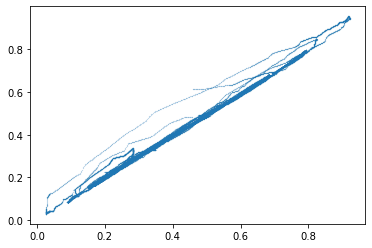

In [78]:
plt.scatter(1-comb_data.x_cent/1280,comb_data.angle_rel,.01)

#### Location and angle of center of view

In [79]:
COV = np.array([-117.2192825,32.7060566])
np.arccos(np.dot(RH_Point-CAM,COV-CAM)/np.linalg.norm(COV-CAM)/np.linalg.norm(RH_Point-CAM))*180/np.pi*2.009419152276295

66.03649611554884

#### Optimize for distance bbox-height relationship

In [84]:
distances = ((comb_data.lon_int**2+comb_data.lat_int**2)**.5).values

In [192]:
min_err = 1e10
best = None
error = []
iis = []
for i in np.arange(.00001,.00005,1e-6):
    est = i/(comb_data.height/720).values
    err = ((distances[:25000]-est[:25000])**2).mean()
    error.append(err)
    iis.append(i)
    if err < min_err:
        min_err = err
        best = i
        
factor = best

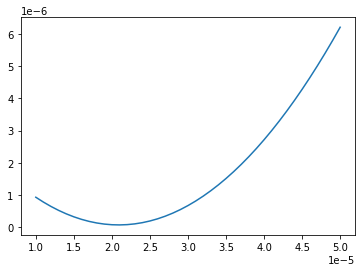

In [193]:
plt.plot(iis,error)

In [194]:
comb_data.head()

,Frame No.,UTC Timestamp,Lat,Long,estimated_time,time,gps_lat,gps_lon,gps_lat_rel,gps_lon_rel,...,y,width,height,x_cent,y_cent,lat_int,lon_int,angles,angle_offset,angle_rel
0,0,19:48:52,32.70297,-117.234631,19:48:56.0,0.000000,NaN,NaN,NaN,NaN,...,426.00,33.0,12.000,1086.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
1,1,19:48:52,32.70297,-117.234631,19:48:56.06,0.055556,NaN,NaN,NaN,NaN,...,426.01,33.0,11.993,1085.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
2,2,19:48:52,32.70297,-117.234631,19:48:56.11,0.111111,NaN,NaN,NaN,NaN,...,426.03,33.0,11.986,1085.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
3,3,19:48:52,32.70297,-117.234631,19:48:56.17,0.166667,NaN,NaN,NaN,NaN,...,426.04,33.0,11.979,1084.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
4,4,19:48:52,32.70297,-117.234631,19:48:56.22,0.222222,NaN,NaN,NaN,NaN,...,426.06,33.0,11.972,1084.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504


#### Observe angle estimator performance on training data

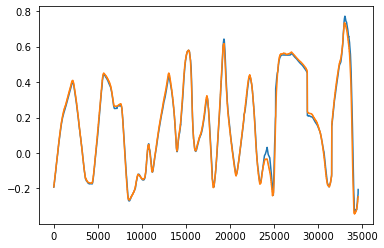

In [198]:
plt.plot(comb_data.angles)
plt.plot((1-comb_data.x_cent.values/1280)*FOV+RHS_Ang)

#### Optimize moving average filter length

In [210]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [214]:
min_err = 1e10
best = None
error = []
iis = []
for i in range(50,700):
    est = moving_average(factor/(comb_data[:25000].height.values/720),n=i)
    err = ((distances[:25001-i]-est[:25000])**2).mean()
    error.append(err)
    iis.append(i)
    if err < min_err:
        min_err = err
        best = i
        
window = best

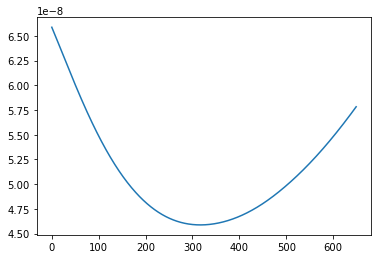

In [216]:
plt.plot(error)

In [217]:
window

367

#### Observe filtered distance estimator performance on training data

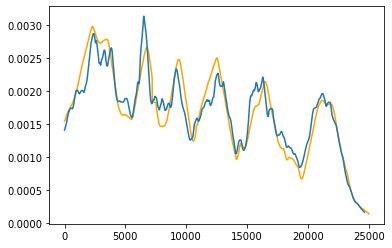

In [230]:
plt.plot(distances[:25000],color='orange')
plt.plot(moving_average(factor/(comb_data[:25000].height.values/720),n=367))

#### Use simple estimators to estimate latlon from bbox data

In [221]:
lon = factor/(moving_average(comb_data.height.values,window)/720)*np.cos((1-comb_data.x_cent.values[:34218]/1280)*FOV+RHS_Ang)
lat = factor/(moving_average(comb_data.height.values,window)/720)*np.sin((1-comb_data.x_cent.values[:34218]/1280)*FOV+RHS_Ang)
lont = distances*np.cos(comb_data.angle_offset+RHS_Ang)
latt = distances*np.sin(comb_data.angle_offset+RHS_Ang)

In [243]:
lon_mse = ((lon[:25000]-lont[:25000])**2).mean()
lat_mse = ((lat[:25000]-latt[:25000])**2).mean()
(lon_mse*288200**2+lat_mse*364000**2)**.5

62.16415483905954

    The above number indicates that on these training data, the simple estimator is off by an average of 62 feet on the first 25000 data points (before the boat travels beyond the resolution of the camera and the system breaks down)
#### Observe perfomance of simple estimators on training data

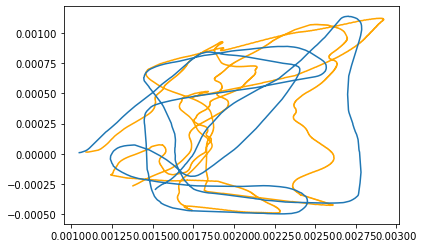

In [244]:
plt.plot(lon[:14000],lat[:14000],color='orange')
plt.plot(lont[:14000],latt[:14000])

#### Try to approximate the nonlinear transformation from screen position/size to distance

In [80]:
model = keras.models.Sequential([
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(2, activation = 'linear')
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()],
)


In [207]:
maxes = np.array([max(full_data_6.lon_lin),max(full_data_6.lat_lin)])

In [212]:
model.fit((full_data_6[['x','y']].values/np.array([1280,720]))[:3000],full_data_6[['R','angles']].values[:3000],#/maxes,
          validation_data =(full_data_6[['x','y']].values[3000:]/np.array([1280,720]),full_data_6[['R','angles']].values[3000:]),#/maxes), 
         batch_size = 8,
         epochs = 50,
         verbose = 1)

Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 4.3255e-04 - val_mean_squared_error: 4.3255e-04
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2359e-04 - mean_squared_error: 1.2359e-04 - val_loss: 4.2599e-04 - val_mean_squared_error: 4.2599e-04
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2431e-04 - mean_squared_error: 1.2431e-04 - val_loss: 4.1176e-04 - val_mean_squared_error: 4.1176e-04
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2078e-04 - mean_squared_error: 1.2078e-04 - val_loss: 3.6795e-04 - val_mean_squared_error: 3.6795e-04
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2858e-04 - mean_squared_error: 1.2858e-04 - val_loss: 4.2737e-04 - val_mean_squared_error: 4.2737e-04
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3309e-04 - mean_squared_error: 1.3309e-04 

Epoch 47/50
375/375 [==============================] - 1s 2ms/step - loss: 1.4276e-04 - mean_squared_error: 1.4276e-04 - val_loss: 5.4665e-04 - val_mean_squared_error: 5.4665e-04
Epoch 48/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3209e-04 - mean_squared_error: 1.3209e-04 - val_loss: 2.7948e-04 - val_mean_squared_error: 2.7948e-04
Epoch 49/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3109e-04 - mean_squared_error: 1.3109e-04 - val_loss: 4.0475e-04 - val_mean_squared_error: 4.0475e-04
Epoch 50/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3341e-04 - mean_squared_error: 1.3341e-04 - val_loss: 6.9234e-04 - val_mean_squared_error: 6.9234e-04


In [213]:
pred = model.predict(full_data_6[['x','y']].values[:]/np.array([1280,720]))

In [218]:
data = full_data_6

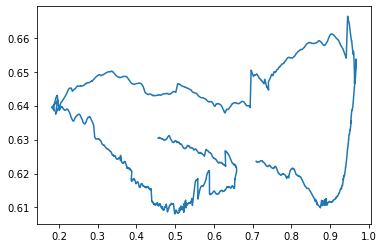

In [223]:
plt.plot(data.x/1280,data.y/720)

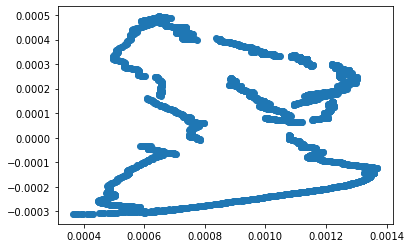

In [211]:
plt.scatter(pred[:,0]*maxes[0],pred[:,1]*maxes[1])

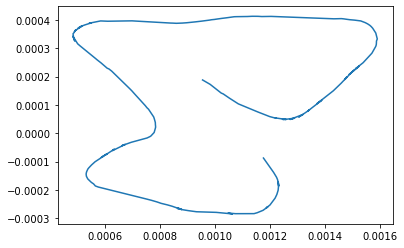

In [184]:
plt.plot(full_data_6.lon_lin.values[:],full_data_6.lat_lin.values[:])